# Analyzing Preorder Data

In [24]:
import pandas as pd
#cleaning data -> removing na columns -> prevent incomplete analysis
pre_order_data_frame = pd.read_csv('Inflight Service_Pre order data.csv').dropna()

# Removing irrelevant data -> 'record_locator', 'carrier_code', 'scheduled_departure_dtl', 'meal_description'
useful_data = pre_order_data_frame.drop(columns=['record_locator', 'carrier_code', 'scheduled_departure_dtl', 'meal_description'])

# Display the first few rows of the cleaned DataFrame
useful_data

,flight_number,departure_station_code,arrival_station_code,cabin_code,meal_group,meal_category,meal_short_description,is_entree,pre_order_qty
0,1423,INX,DEX,J,ENTREES HOT,POULTRY,"Za'atar chicken with spinach, roasted peppers,...",Y,1
1,1620,IAX,CUX,J,ENTREES HOT,BREAKFAST,Tomato and kale baked egg,Y,2
2,1852,ORX,PDX,J,ENTREES HOT,BREAKFAST,Tomato and kale baked egg,Y,1
3,548,IAX,SFX,J,ENTREES HOT,BREAKFAST,Scrambled eggs,Y,2
4,1155,IAX,CUX,J,ENTREES HOT,BREAKFAST,Belgium waffle,Y,2
...,...,...,...,...,...,...,...,...,...
211994,1604,ORX,PHX,J,ENTREES HOT,POULTRY,"Za'atar chicken with spinach, roasted peppers,...",Y,1
211995,2145,IAX,CMX,J,ENTREES HOT,BEEF/VEAL,Brioche cheeseburger,Y,1
211996,2046,DEX,TPX,J,ENTREES HOT,BREAKFAST,Belgium waffle,Y,1
211997,2130,SAX,IAX,Y,UNITED CATERER OWNED 88-3F,SNACKS,Takeoff,N,1


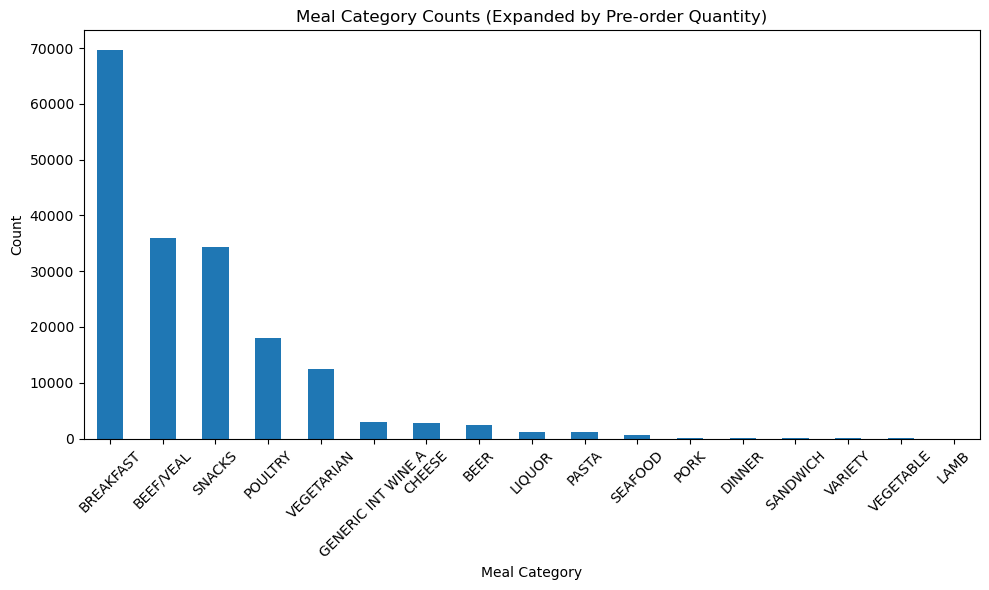

In [29]:
import matplotlib.pyplot as plt

# Expand data based on pre_order_qty
expanded_data = useful_data.loc[useful_data.index.repeat(useful_data['pre_order_qty'])]

# Count of meals per meal category in expanded data
expanded_meal_category_counts = expanded_data['meal_category'].value_counts()

# Create a bar plot for the expanded data
plt.figure(figsize=(10, 6))
expanded_meal_category_counts.plot(kind='bar')
plt.title('Meal Category Counts (Expanded by Pre-order Quantity)')
plt.xlabel('Meal Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

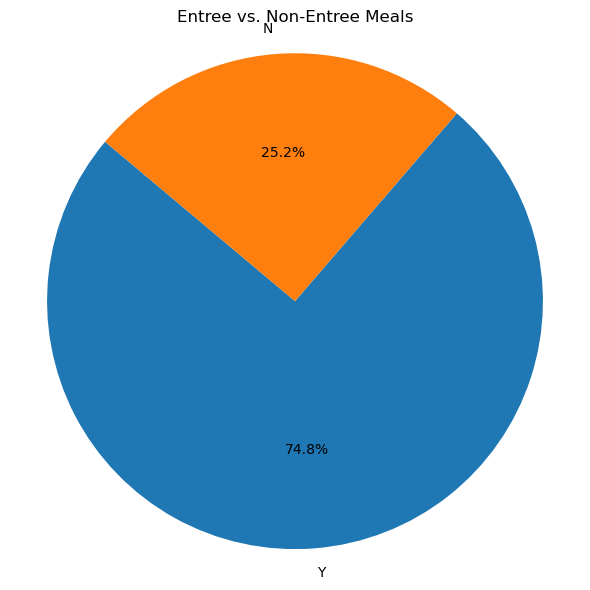

In [27]:
# Count of entree vs. non-entree meals
entree_counts = useful_data['is_entree'].value_counts()

# Create a pie chart
plt.figure(figsize=(6, 6))
plt.pie(entree_counts, labels=entree_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Entree vs. Non-Entree Meals')
plt.axis('equal')
plt.tight_layout()
plt.show()

In [34]:
common_meal_descriptions = useful_data['meal_short_description'].value_counts().head(10)
print(common_meal_descriptions)

Brioche cheeseburger                                       23515
Scrambled eggs                                             19488
Belgium waffle                                             13270
Takeoff                                                    11422
Tapas                                                      11159
Tomato and kale baked egg                                   8446
Za'atar chicken with spinach, roasted peppers, and orzo     6460
Mediterranean Falafel Bowl                                  5667
Horchata steel cut oatmeal                                  5065
Gingerbread French Toast                                    3880
Name: meal_short_description, dtype: int64


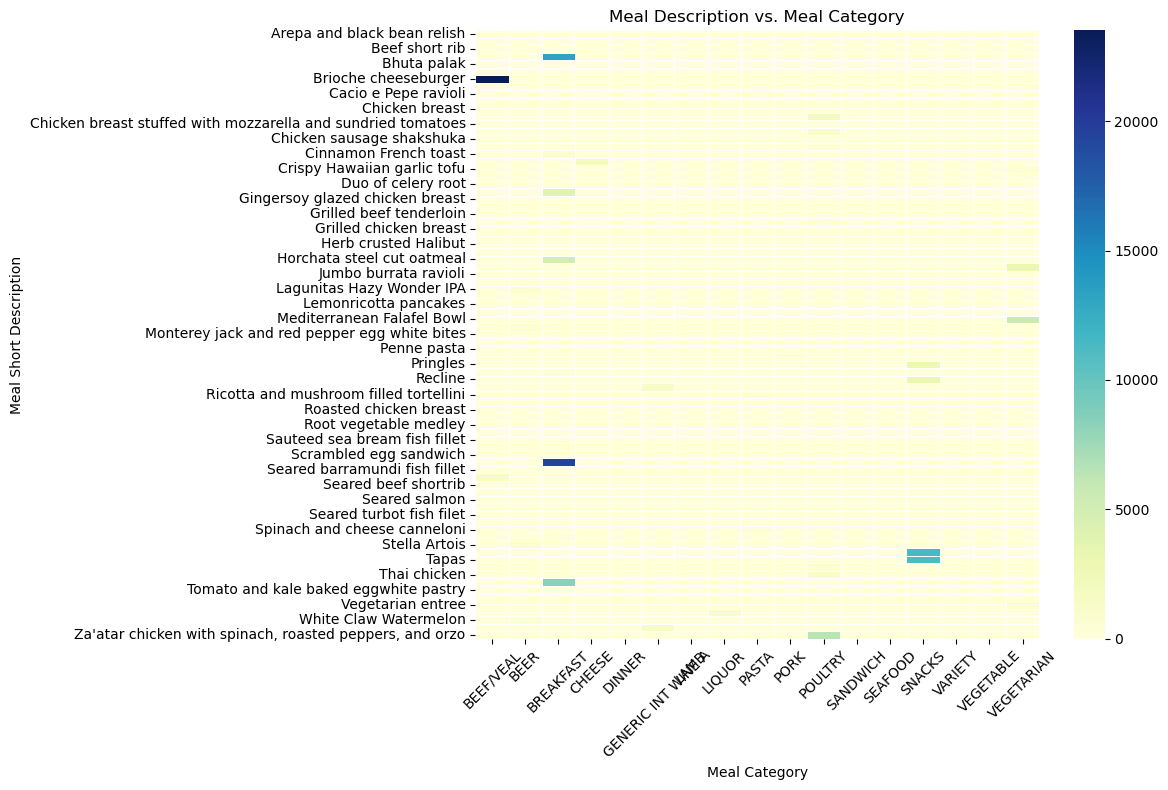

In [35]:
#SUMMARIZING FINDINGS

import seaborn as sns
import matplotlib.pyplot as plt

# Create a pivot table to show the counts of meal descriptions by category
pivot_table = useful_data.pivot_table(index='meal_short_description', columns='meal_category', aggfunc='size', fill_value=0)

# Create a heatmap to visualize the relationship with flipped axes
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, cmap='YlGnBu', linewidths=0.5)
plt.title('Meal Description vs. Meal Category')
plt.xlabel('Meal Category')
plt.ylabel('Meal Short Description')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Prepare data
X = useful_data[['meal_category', 'cabin_code', 'pre_order_qty']]
y = (useful_data['is_entree'] == 'Y').astype(int)  # Convert 'Y' to 1, 'N' to 0

# One-hot encode categorical features
encoder = OneHotEncoder()
X_encoded = encoder.fit_transform(X[['meal_category', 'cabin_code']])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Train a Logistic Regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6983
           1       1.00      1.00      1.00     20430

    accuracy                           1.00     27413
   macro avg       1.00      1.00      1.00     27413
weighted avg       1.00      1.00      1.00     27413



# Analyzing Inorder Data

In [47]:
inorder_data_frame = pd.read_csv("Inflight Service_Inventory data.csv").dropna()
inorder_data_frame

,flight_number,departure_station_code,arrival_station_code,scheduled_departure_dtl,entree_product_id,entree_description,entree_code,planned_entree_count,consumed_entree_count
0,2634,IAX,PDX,9/1/2022,58019,Belgium waffle,WF,20,32
1,2666,ORX,IAX,9/1/2022,60549,Vegetarian chili and polenta cake,V,3,0
2,2310,DEX,SAX,9/2/2022,58981,Scrambled eggs,O,9,7
3,1712,SFX,CLX,9/4/2022,58764,Mediterranean Falafel Bowl,V,1,0
4,1225,LAX,HNX,9/8/2022,60549,Vegetarian chili and polenta cake,V,1,0
...,...,...,...,...,...,...,...,...,...
61262,711,ORX,AUX,9/20/2022,61524,Scrambled eggs,O,6,5
61263,1914,IAX,LAX,9/30/2022,61360,Brioche cheeseburger,B,3,0
61264,1417,IAX,LAX,9/23/2022,60987,Impossible Meatball Bowl,V,6,5
61265,1005,LAX,ITX,9/30/2022,54759,Seared beef short rib,B,6,0


In [49]:
# Calculate the difference between planned_entree_count and consumed_entree_count
inorder_data_frame['stock_difference'] = inorder_data_frame['planned_entree_count'] - inorder_data_frame['consumed_entree_count']

inorder_data_frame

,flight_number,departure_station_code,arrival_station_code,scheduled_departure_dtl,entree_product_id,entree_description,entree_code,planned_entree_count,consumed_entree_count,stock_difference
0,2634,IAX,PDX,9/1/2022,58019,Belgium waffle,WF,20,32,-12
1,2666,ORX,IAX,9/1/2022,60549,Vegetarian chili and polenta cake,V,3,0,3
2,2310,DEX,SAX,9/2/2022,58981,Scrambled eggs,O,9,7,2
3,1712,SFX,CLX,9/4/2022,58764,Mediterranean Falafel Bowl,V,1,0,1
4,1225,LAX,HNX,9/8/2022,60549,Vegetarian chili and polenta cake,V,1,0,1
...,...,...,...,...,...,...,...,...,...,...
61262,711,ORX,AUX,9/20/2022,61524,Scrambled eggs,O,6,5,1
61263,1914,IAX,LAX,9/30/2022,61360,Brioche cheeseburger,B,3,0,3
61264,1417,IAX,LAX,9/23/2022,60987,Impossible Meatball Bowl,V,6,5,1
61265,1005,LAX,ITX,9/30/2022,54759,Seared beef short rib,B,6,0,6


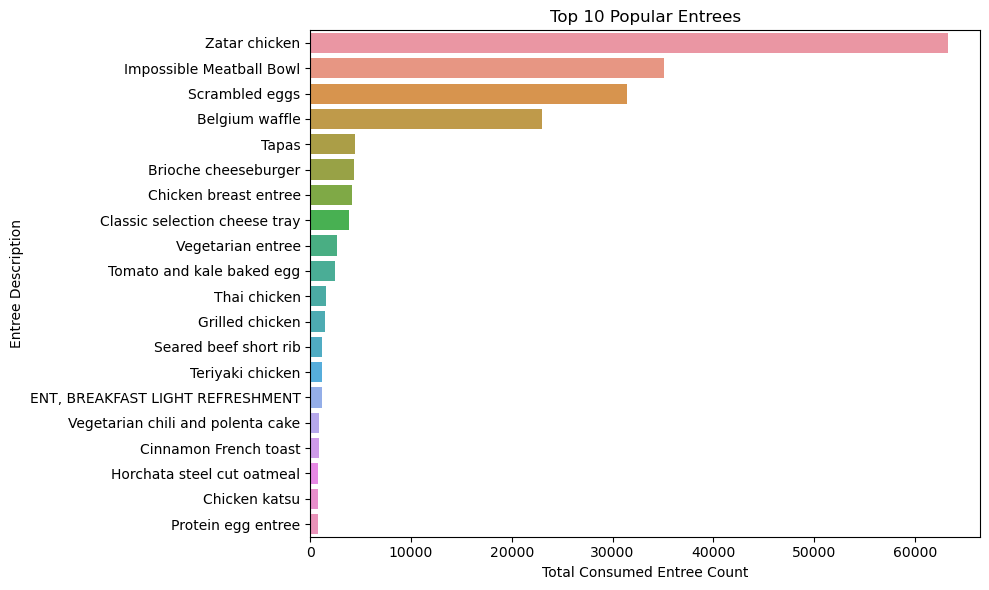

In [56]:
# Calculate total consumed_entree_count per entree description
entree_consumption = inorder_data_frame.groupby('entree_description')['consumed_entree_count'].sum()

top_entrees = entree_consumption.nlargest(20)

# Create a horizontal bar plot for top popular entrees
plt.figure(figsize=(10, 6))
sns.barplot(x=top_entrees.values, y=top_entrees.index)
plt.xlabel('Total Consumed Entree Count')
plt.ylabel('Entree Description')
plt.title(f'Top {top_n} Popular Entrees')
plt.tight_layout()
plt.show()

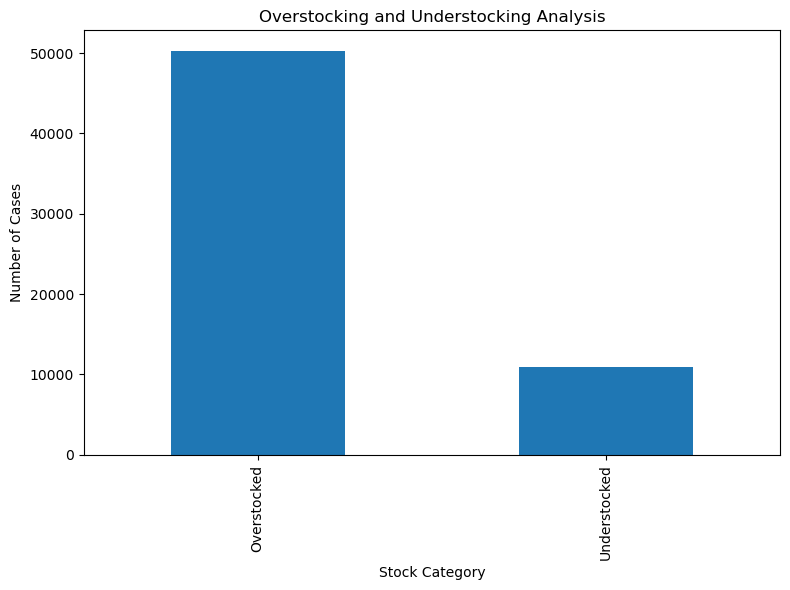

In [54]:
# Categorize stock difference into overstocked, understocked, and balanced cases
inorder_data_frame['stock_category'] = pd.cut(inorder_data_frame['stock_difference'], bins=[-float('inf'), 0, float('inf')], labels=['Understocked', 'Overstocked'])

# Count the occurrences of each stock category
stock_category_counts = inorder_data_frame['stock_category'].value_counts()

# Create a stacked bar plot for overstocking and understocking analysis
plt.figure(figsize=(8, 6))
stock_category_counts.plot(kind='bar', stacked=True)
plt.xlabel('Stock Category')
plt.ylabel('Number of Cases')
plt.title('Overstocking and Understocking Analysis')
plt.tight_layout()
plt.show()

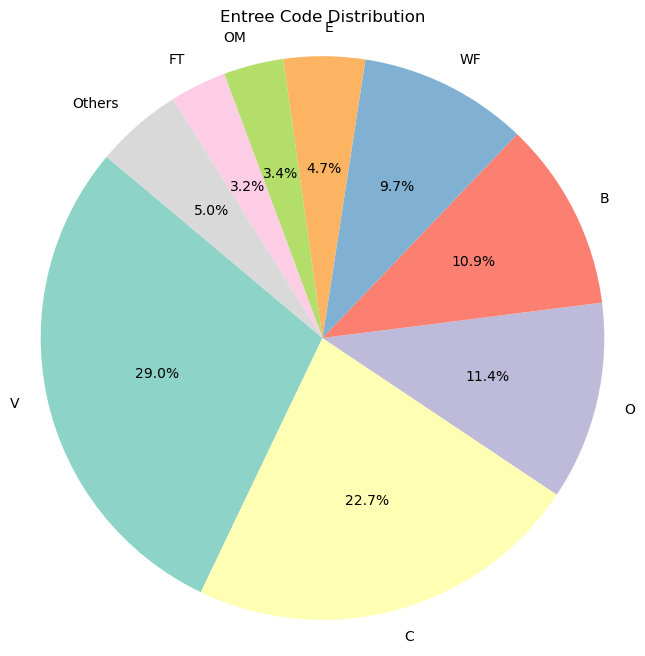

In [68]:
entree_code_counts = inorder_data_frame['entree_code'].value_counts()

total_count = entree_code_counts.sum()

threshold_count = total_count * 3 / 100

included_entree_codes = entree_code_counts[entree_code_counts >= threshold_count].index
other_count = total_count - entree_code_counts[included_entree_codes].sum()
entree_code_counts = entree_code_counts[included_entree_codes]
entree_code_counts['Others'] = other_count

plt.figure(figsize=(8, 8))
plt.pie(entree_code_counts, labels=entree_code_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('Set3', n_colors=len(entree_code_counts)))
plt.title('Entree Code Distribution')
plt.axis('equal')
plt.show()


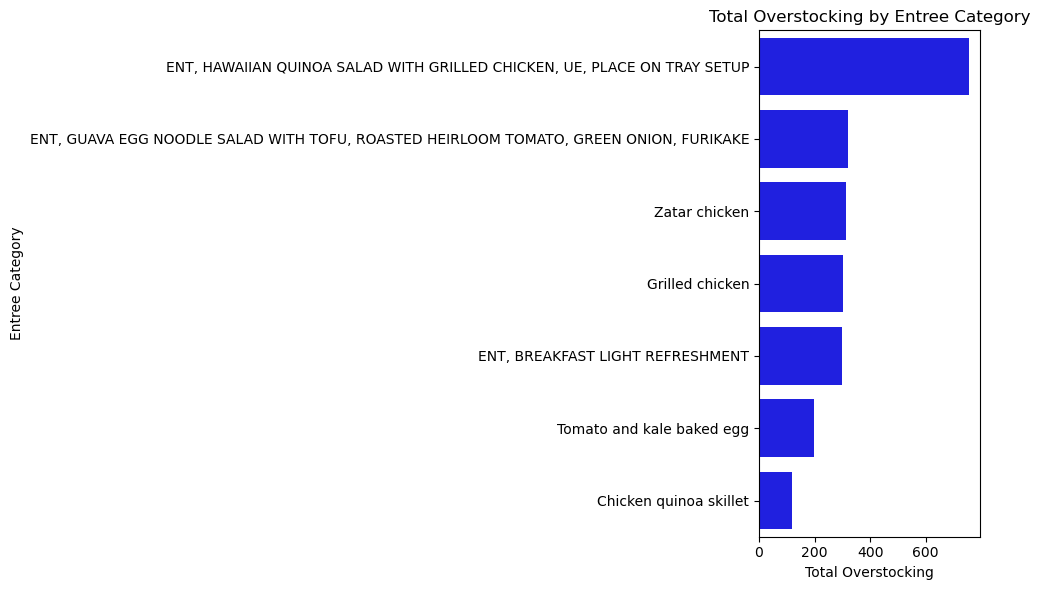

In [76]:
# Calculate stock difference
inorder_data_frame['stock_difference'] = inorder_data_frame['planned_entree_count'] - inorder_data_frame['consumed_entree_count']

# Select top 20 deviations
top_deviations = inorder_data_frame.nlargest(20, 'stock_difference', 'all')

# Extract entree category from description (assuming description format is "Category: Description")
top_deviations['entree_category'] = top_deviations['entree_description'].apply(lambda x: x.split(':')[0])

# Calculate total overstocking per category
overstock_by_category = top_deviations[top_deviations['stock_difference'] > 0].groupby('entree_category')['stock_difference'].sum().reset_index()
overstock_by_category = overstock_by_category.sort_values(by='stock_difference', ascending=False)

# Visualize overstocking by category
plt.figure(figsize=(10, 6))
sns.barplot(data=overstock_by_category, x='stock_difference', y='entree_category', color='blue')
plt.xlabel('Total Overstocking')
plt.ylabel('Entree Category')
plt.title('Total Overstocking by Entree Category')
plt.tight_layout()
plt.show()


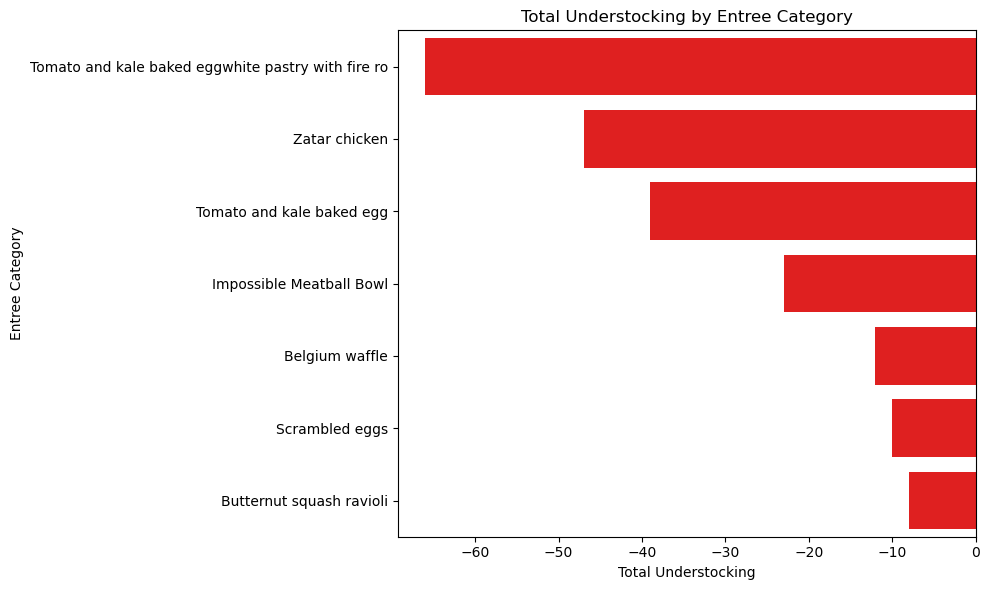

In [77]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate stock difference
inorder_data_frame['stock_difference'] = inorder_data_frame['planned_entree_count'] - inorder_data_frame['consumed_entree_count']

# Select top 20 deviations
top_deviations = inorder_data_frame.nsmallest(20, 'stock_difference', 'all')

# Extract entree category from description (assuming description format is "Category: Description")
top_deviations['entree_category'] = top_deviations['entree_description'].apply(lambda x: x.split(':')[0])

# Calculate total understocking per category
understock_by_category = top_deviations[top_deviations['stock_difference'] < 0].groupby('entree_category')['stock_difference'].sum().reset_index()
understock_by_category = understock_by_category.sort_values(by='stock_difference', ascending=True)

# Visualize understocking by category
plt.figure(figsize=(10, 6))
sns.barplot(data=understock_by_category, x='stock_difference', y='entree_category', color='red')
plt.xlabel('Total Understocking')
plt.ylabel('Entree Category')
plt.title('Total Understocking by Entree Category')
plt.tight_layout()
plt.show()


In [81]:
satisfaction_score_data_frame = pd.read_csv("Survey data_Inflight Satisfaction Score.csv").dropna()
satisfaction_score_data_frame

,flight_number,origin_station_code,destination_station_code,record_locator,scheduled_departure_date,question_text,score,satisfaction_type,driver_sub_group1,driver_sub_group2,arrival_delay_minutes,arrival_delay_group,cabin_code_desc,cabin_name,entity,number_of_legs,seat_factor_band,loyalty_program_level,generation,fleet_type_description,fleet_usage,equipment_type_code,ua_uax,actual_flown_miles,haul_type,departure_gate,arrival_gate,international_domestic_indicator,response_group,media_provider,hub_spoke
9,4635,ASX,DEX,BNXXXJ,9/1/2022,How satisfied were you with the food & beverag...,3,Dissatisfied,food & beverage,food and beverage satisfaction,55,Delayed,Economy,Economy,Domestic,2,90+,non-elite,Boomer,CRJ-700,Express,CR7,UAX,126,Short,3,B55,Domestic,member,GOGO,spoke departure
13,1646,IAX,AUX,MMXXPM,9/1/2022,How satisfied were you with the food & beverag...,1,Dissatisfied,food & beverage,food and beverage satisfaction,-8,Early & Ontime,Economy,Economy Plus,Domestic,2,0 to 70,premier platinum,Boomer,B737-800,Mainline,73Y,UA,141,Short,C45,27,Domestic,member,THALES,hub departure
15,4749,HDX,DEX,LRXXD6,9/1/2022,How satisfied were you with the food & beverag...,2,Dissatisfied,food & beverage,food and beverage satisfaction,15,Delayed,Economy,Economy,Domestic,2,90+,non-elite,Boomer,ERJ-175,Express,E7Q,UAX,142,Short,3,A77,Domestic,member,GOGO,spoke departure
16,4176,ALX,EWX,AFXX8D,9/1/2022,How satisfied were you with the food & beverag...,3,Dissatisfied,food & beverage,food and beverage satisfaction,46,Delayed,Economy,Economy,Domestic,2,90+,non-elite,Boomer,CRJ-550,Express,C5G,UAX,143,Short,A4,A28,Domestic,member,GOGO,spoke departure
20,3632,ORX,INX,A0XXRT,9/1/2022,How satisfied were you with the food & beverag...,1,Dissatisfied,food & beverage,food and beverage satisfaction,-27,Early & Ontime,Economy,Economy,Domestic,2,90+,non-elite,Gen X,ERJ-170,Express,E7R,UAX,177,Short,C7,A24,Domestic,member,GOGO,hub departure
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47044,872,SFX,TPX,LQXX36,9/30/2022,How satisfied were you with the food & beverag...,1,Dissatisfied,food & beverage,food and beverage satisfaction,55,Delayed,Economy,Economy,Pacific,1,80+,non-elite,Gen X,B777-300,Mainline,77X,UA,6469,Long,G2,D6,International,member,PANASONIC,hub departure
47059,840,LAX,SYX,G1XX9G,9/30/2022,How satisfied were you with the food & beverag...,4,Satisfied,food & beverage,food and beverage satisfaction,-6,Early & Ontime,Economy,Economy,Pacific,3,80+,non-elite,Boomer,B787-9,Mainline,78P,UA,7487,Long,74,54,International,member,PANASONIC,hub departure
47060,840,LAX,SYX,JHXXVW,9/30/2022,How satisfied were you with the food & beverag...,2,Dissatisfied,food & beverage,food and beverage satisfaction,-6,Early & Ontime,Economy,Economy,Pacific,1,80+,non-elite,Boomer,B787-9,Mainline,78P,UA,7487,Long,74,54,International,member,PANASONIC,hub departure
47067,188,JNX,EWX,E6XXCG,9/30/2022,How satisfied were you with the food & beverag...,3,Dissatisfied,food & beverage,food and beverage satisfaction,-22,Early & Ontime,Economy,Economy Plus,Atlantic,1,70+,non-elite,Gen X,B787-9,Mainline,78P,UA,7989,Long,A11,B65,International,member,PANASONIC,spoke departure


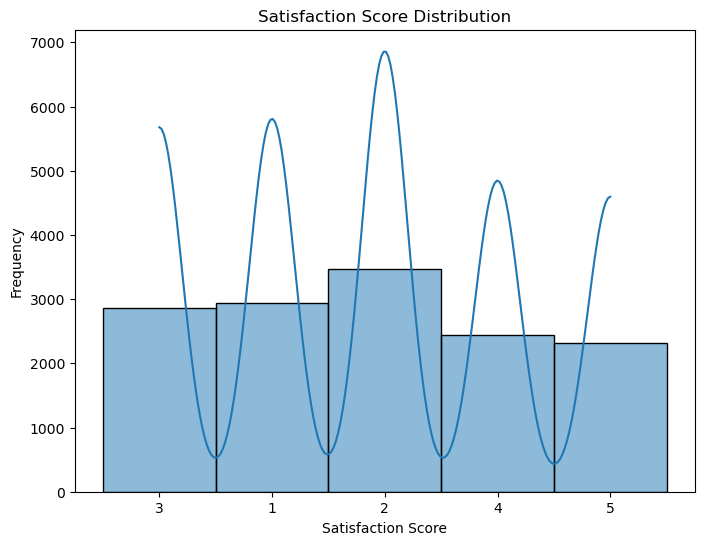

In [82]:
# Explore satisfaction score distribution
plt.figure(figsize=(8, 6))
sns.histplot(data=satisfaction_score_data_frame, x='score', bins=5, kde=True)
plt.xlabel('Satisfaction Score')
plt.ylabel('Frequency')
plt.title('Satisfaction Score Distribution')
plt.show()

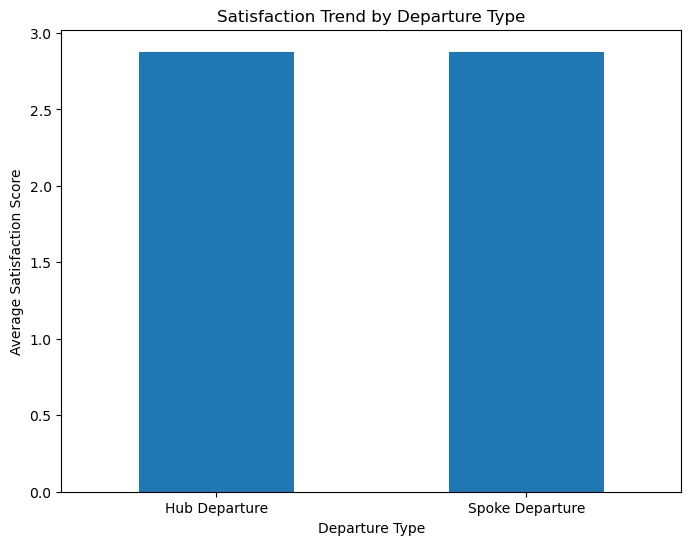

In [92]:
satisfaction_score_data_frame['score'] = pd.to_numeric(satisfaction_score_data_frame['score'], errors='coerce')

# Calculate the mean satisfaction score by hub_spoke_mapped
hub_spoke_score_trend = satisfaction_score_data_frame.groupby('hub_spoke_mapped')['score'].mean()

# Plot the trend
plt.figure(figsize=(8, 6))
hub_spoke_score_trend.plot(kind='bar')
plt.xticks([0, 1], ['Hub Departure', 'Spoke Departure'], rotation=0)
plt.xlabel('Departure Type')
plt.ylabel('Average Satisfaction Score')
plt.title('Satisfaction Trend by Departure Type')
plt.show()


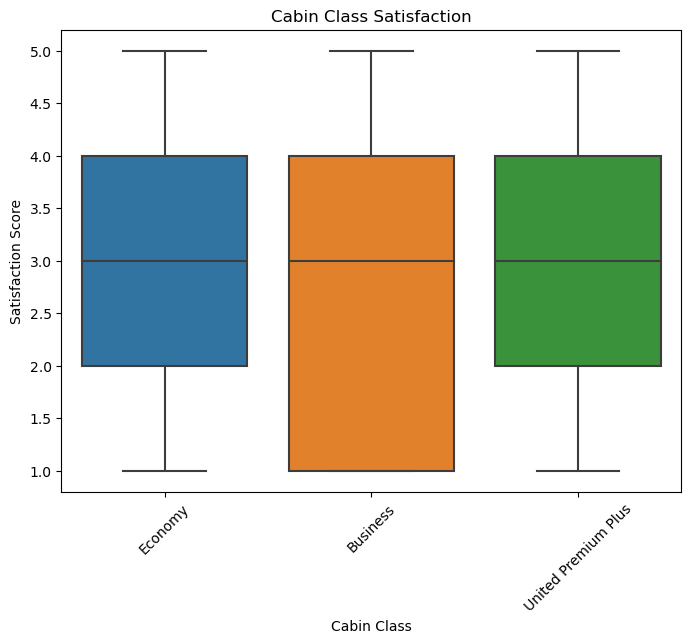

In [93]:
import matplotlib.pyplot as plt
import seaborn as sns

# Analyze satisfaction by cabin class
plt.figure(figsize=(8, 6))
sns.boxplot(data=satisfaction_score_data_frame, x='cabin_code_desc', y='score')
plt.xlabel('Cabin Class')
plt.ylabel('Satisfaction Score')
plt.title('Cabin Class Satisfaction')
plt.xticks(rotation=45)
plt.show()


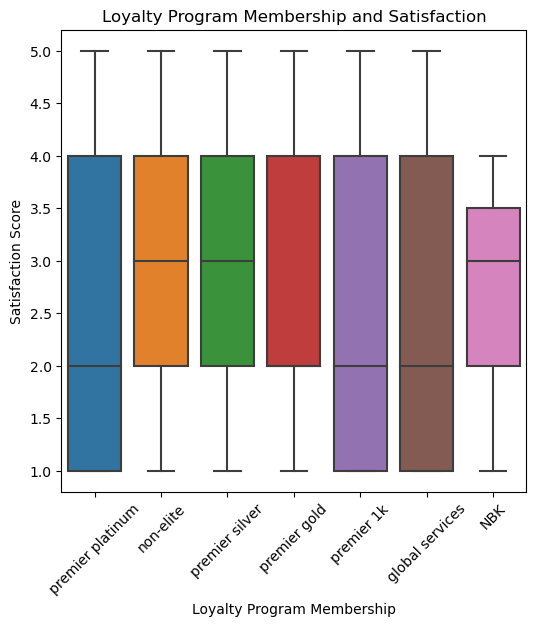

In [96]:
# Explore satisfaction by loyalty program membership
plt.figure(figsize=(6, 6))
sns.boxplot(data=satisfaction_score_data_frame, x='loyalty_program_level', y='score')
plt.xlabel('Loyalty Program Membership')
plt.ylabel('Satisfaction Score')
plt.title('Loyalty Program Membership and Satisfaction')
plt.xticks(rotation=45)
plt.show()


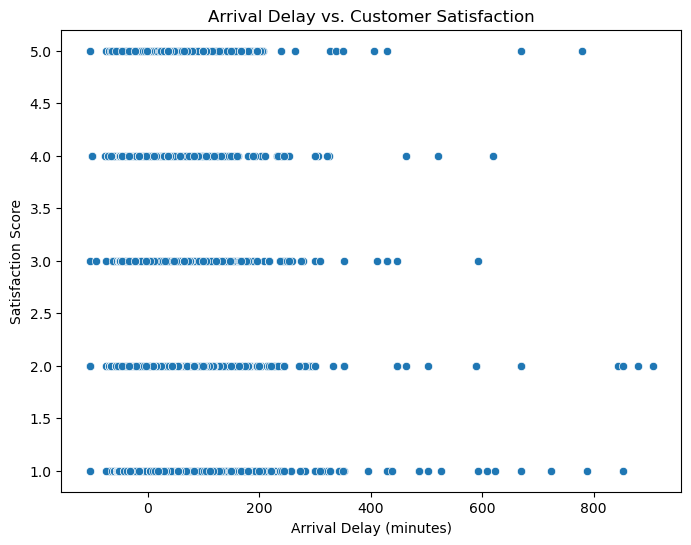

In [97]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=satisfaction_score_data_frame, x='arrival_delay_minutes', y='score')
plt.xlabel('Arrival Delay (minutes)')
plt.ylabel('Satisfaction Score')
plt.title('Arrival Delay vs. Customer Satisfaction')
plt.show()


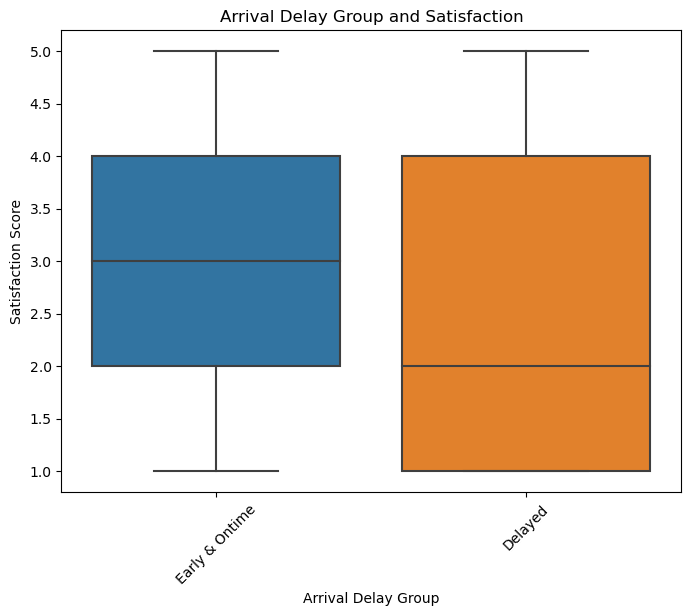

In [98]:
# Explore satisfaction by arrival delay group
plt.figure(figsize=(8, 6))
sns.boxplot(data=satisfaction_score_data_frame, x='arrival_delay_group', y='score')
plt.xlabel('Arrival Delay Group')
plt.ylabel('Satisfaction Score')
plt.title('Arrival Delay Group and Satisfaction')
plt.xticks(rotation=45)
plt.show()


/var/folders/z3/q314db697q95drwc43vlwz040000gp/T/ipykernel_8550/2594924509.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=satisfaction_score_data_frame, x='media_provider', y='score', ci=None)


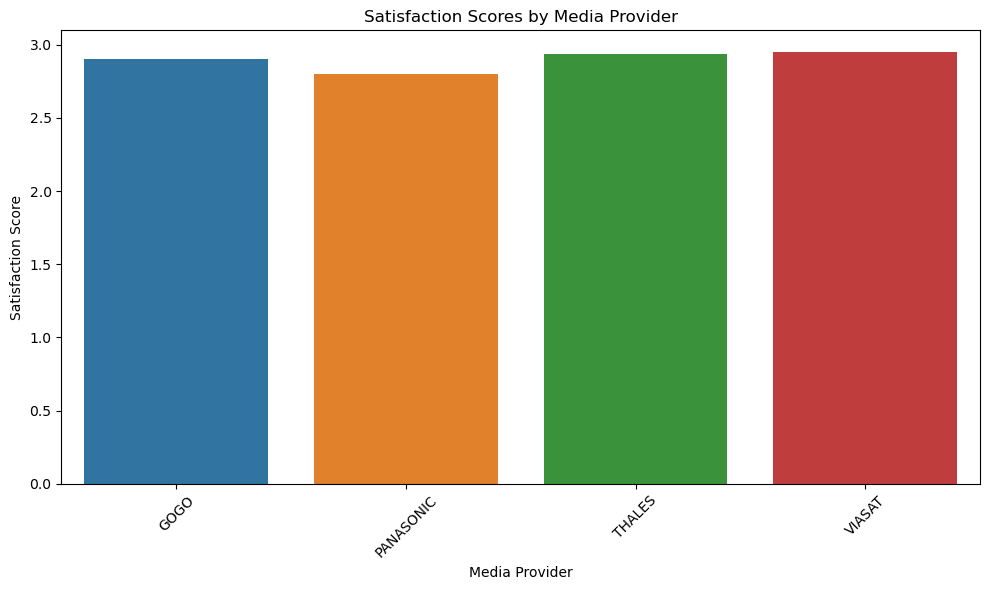

In [105]:
# Create a bar plot of satisfaction scores by media provider
plt.figure(figsize=(10, 6))
sns.barplot(data=satisfaction_score_data_frame, x='media_provider', y='score', ci=None)
plt.xlabel('Media Provider')
plt.ylabel('Satisfaction Score')
plt.title('Satisfaction Scores by Media Provider')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


/var/folders/z3/q314db697q95drwc43vlwz040000gp/T/ipykernel_8550/4050381536.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=satisfaction_score_data_frame, x='haul_type', y='score', ci=None)


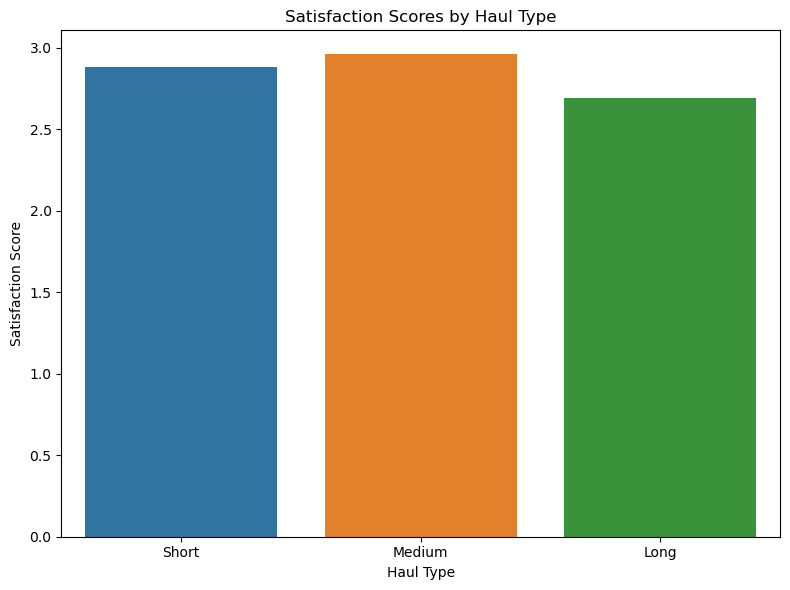

In [106]:
# Create a bar plot of satisfaction scores by haul type
plt.figure(figsize=(8, 6))
sns.barplot(data=satisfaction_score_data_frame, x='haul_type', y='score', ci=None)
plt.xlabel('Haul Type')
plt.ylabel('Satisfaction Score')
plt.title('Satisfaction Scores by Haul Type')
plt.tight_layout()
plt.show()


/var/folders/z3/q314db697q95drwc43vlwz040000gp/T/ipykernel_8550/1227940986.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=satisfaction_score_data_frame, x='generation', y='score', ci=None)


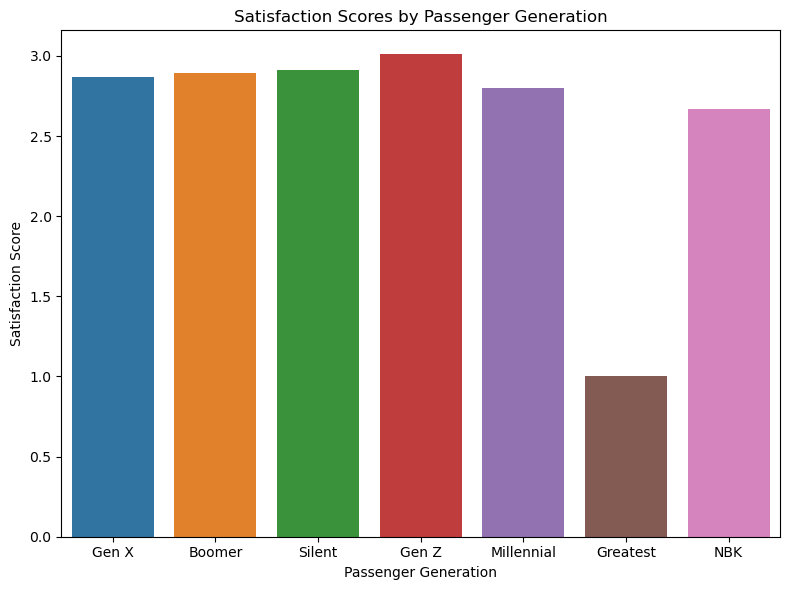

In [107]:
# Create a bar plot of satisfaction scores by generation
plt.figure(figsize=(8, 6))
sns.barplot(data=satisfaction_score_data_frame, x='generation', y='score', ci=None)
plt.xlabel('Passenger Generation')
plt.ylabel('Satisfaction Score')
plt.title('Satisfaction Scores by Passenger Generation')
plt.tight_layout()
plt.show()


In [108]:
customer_comments_data_frame = pd.read_csv("Survey data _Customer comments.csv")
customer_comments_data_frame

,flight_number,origin_station_code,destination_station_code,scheduled_departure_date,arrival_delay_group,departure_delay_group,entity,verbatim_text,seat_factor_band,ques_verbatim_text,loyalty_program_level,fleet_type_description,fleet_usage,response_group
0,950,LHX,SFX,2022-09-01,Early & Ontime,Delayed,Atlantic,There was no salad dressing. The staff informe...,0 to 70,Is there anything else you'd like to share abo...,non-elite,B777-200,Mainline,member
1,950,LHX,SFX,2022-09-01,Early & Ontime,Delayed,Atlantic,Not a choice.,0 to 70,Is there anything else you'd like to share abo...,NaN,B777-200,Mainline,non-member
2,1876,FLX,EWX,2022-09-01,Early & Ontime,Early & Ontime,Domestic,More variety and bigger snacks.,90+,Is there anything else you'd like to share abo...,non-elite,A320-200,Mainline,member
3,5469,SFX,SEX,2022-09-01,Early & Ontime,Early & Ontime,Domestic,Serving pretzels and cookies in first class wa...,90+,Is there anything else you'd like to share abo...,premier gold,ERJ-175,Express,member
4,281,DEX,ANX,2022-09-01,Early & Ontime,Early & Ontime,Domestic,More inflight selections to purchase for full ...,0 to 70,Is there anything else you'd like to share abo...,non-elite,B737-MAX8,Mainline,member
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9419,2175,YYX,ORX,2022-09-30,Early & Ontime,Early & Ontime,Domestic,tapas box needs better pita chips. the provide...,90+,Is there anything else you'd like to share abo...,premier gold,B737-700,Mainline,member
9420,680,DEX,GRX,2022-09-30,Delayed,Delayed,Domestic,My flight attendant missed my drink order 2x a...,80+,Is there anything else you'd like to share abo...,global services,B737-900,Mainline,member
9421,1420,CLX,FLX,2022-09-29,Delayed,Early & Ontime,Domestic,Mo.,70+,Is there anything else you'd like to share abo...,premier platinum,B737-800,Mainline,member
9422,4746,LAX,EUX,2022-09-30,Early & Ontime,Early & Ontime,Domestic,"without a smartphone, not much to eat. we pack...",80+,Is there anything else you'd like to share abo...,NaN,ERJ-175,Express,non-member


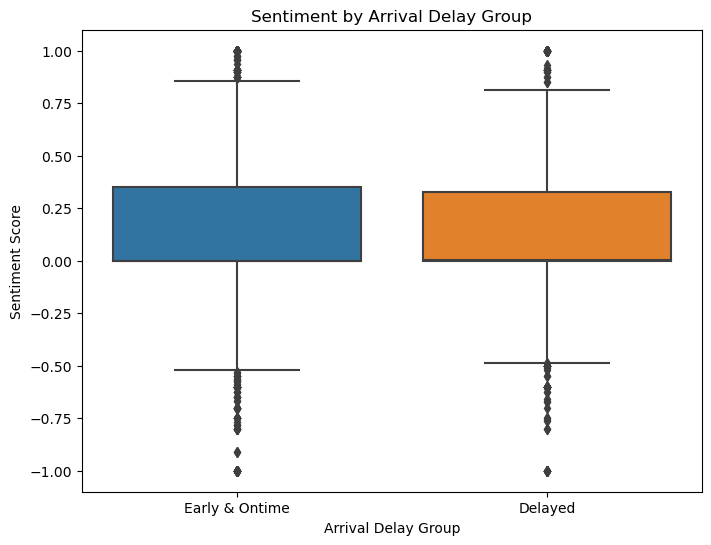

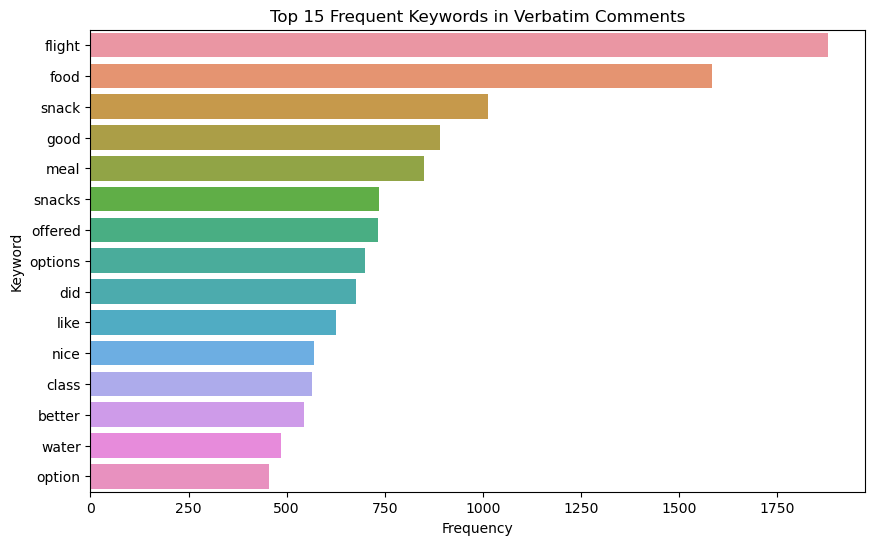

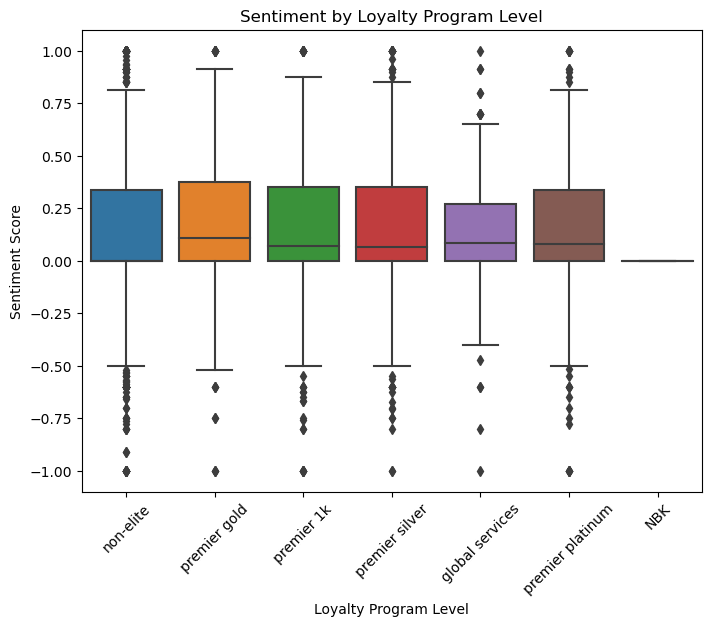

In [111]:
import pandas as pd
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns

# Load the customer comments data
customer_comments_data_frame = pd.read_csv("Survey data _Customer comments.csv")

# Sentiment Analysis using TextBlob
def analyze_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

customer_comments_data_frame['sentiment_score'] = customer_comments_data_frame['verbatim_text'].apply(analyze_sentiment)

# Analyze sentiment by arrival delay group
plt.figure(figsize=(8, 6))
sns.boxplot(data=customer_comments_data_frame, x='arrival_delay_group', y='sentiment_score')
plt.xlabel('Arrival Delay Group')
plt.ylabel('Sentiment Score')
plt.title('Sentiment by Arrival Delay Group')
plt.show()

# Analyze frequent keywords in verbatim comments
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(customer_comments_data_frame['verbatim_text'])
keywords = vectorizer.get_feature_names_out()

word_frequencies = X.sum(axis=0).A1
keyword_frequency = pd.DataFrame({'Keyword': keywords, 'Frequency': word_frequencies})
keyword_frequency = keyword_frequency.sort_values(by='Frequency', ascending=False)

# Plot frequent keywords
plt.figure(figsize=(10, 6))
sns.barplot(x='Frequency', y='Keyword', data=keyword_frequency.head(15))
plt.xlabel('Frequency')
plt.ylabel('Keyword')
plt.title('Top 15 Frequent Keywords in Verbatim Comments')
plt.show()

# Analyze sentiment by loyalty program level
plt.figure(figsize=(8, 6))
sns.boxplot(data=customer_comments_data_frame, x='loyalty_program_level', y='sentiment_score')
plt.xlabel('Loyalty Program Level')
plt.ylabel('Sentiment Score')
plt.title('Sentiment by Loyalty Program Level')
plt.xticks(rotation=45)
plt.show()


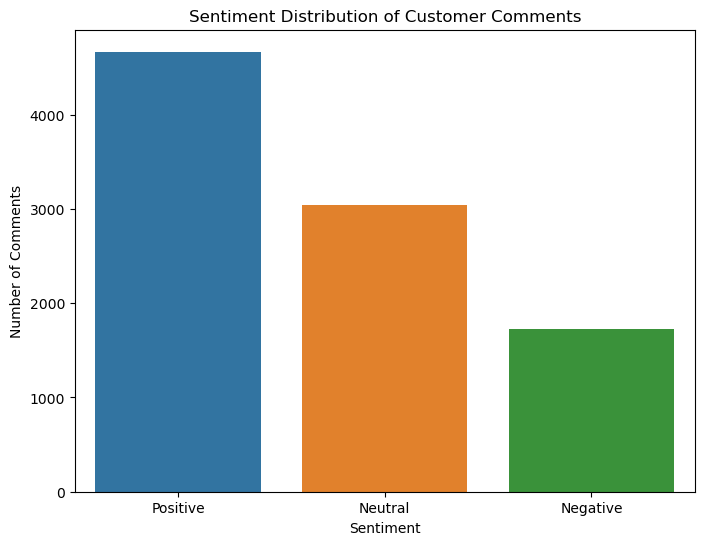

In [112]:
import pandas as pd
from textblob import TextBlob

# Load the customer comments data frame
customer_comments_data_frame = pd.read_csv("Survey data _Customer comments.csv")

# Perform sentiment analysis on verbatim_text
def get_sentiment(text):
    analysis = TextBlob(text)
    if analysis.sentiment.polarity > 0:
        return 'Positive'
    elif analysis.sentiment.polarity < 0:
        return 'Negative'
    else:
        return 'Neutral'

# Apply sentiment analysis to verbatim_text column
customer_comments_data_frame['sentiment'] = customer_comments_data_frame['verbatim_text'].apply(get_sentiment)

# Count the number of positive, negative, and neutral comments
sentiment_counts = customer_comments_data_frame['sentiment'].value_counts()

# Plot the sentiment distribution
plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values)
plt.xlabel('Sentiment')
plt.ylabel('Number of Comments')
plt.title('Sentiment Distribution of Customer Comments')
plt.show()


<Figure size 1200x800 with 0 Axes>

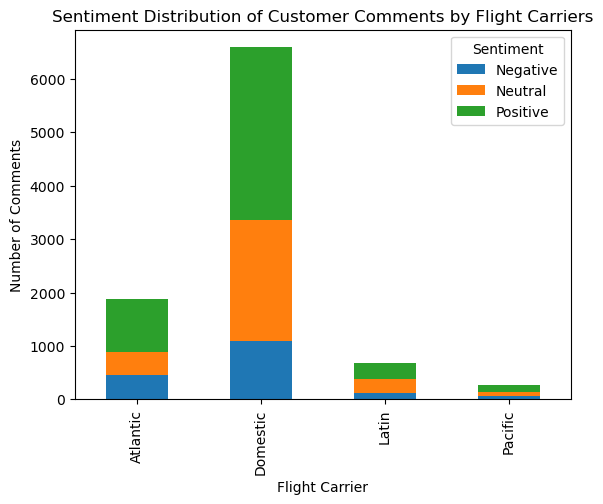

In [113]:
import pandas as pd
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns

# Load the customer comments data frame
customer_comments_data_frame = pd.read_csv("Survey data _Customer comments.csv")

# Perform sentiment analysis on verbatim_text
def get_sentiment(text):
    analysis = TextBlob(text)
    if analysis.sentiment.polarity > 0:
        return 'Positive'
    elif analysis.sentiment.polarity < 0:
        return 'Negative'
    else:
        return 'Neutral'

# Apply sentiment analysis to verbatim_text column
customer_comments_data_frame['sentiment'] = customer_comments_data_frame['verbatim_text'].apply(get_sentiment)

# Group sentiment by flight carriers
sentiment_by_carrier = customer_comments_data_frame.groupby(['entity', 'sentiment']).size().unstack(fill_value=0)

# Plot the sentiment distribution for each carrier
plt.figure(figsize=(12, 8))
sentiment_by_carrier.plot(kind='bar', stacked=True)
plt.xlabel('Flight Carrier')
plt.ylabel('Number of Comments')
plt.title('Sentiment Distribution of Customer Comments by Flight Carriers')
plt.legend(title='Sentiment')
plt.show()
